In [3]:
env = BlackjackEnv()

In [ ]:
%matplotlib inline


# Solving Blackjack with Q-Learning


<img src="file://_static/img/tutorials/blackjack_AE_loop.jpg" width="650" alt="agent-environment-diagram" class="only-light">
<img src="file://_static/img/tutorials/blackjack_AE_loop_dark.png" width="650" alt="agent-environment-diagram" class="only-dark">

In this tutorial, we’ll explore and solve the *Blackjack-v1*
environment.

**Blackjack** is one of the most popular casino card games that is also
infamous for being beatable under certain conditions. This version of
the game uses an infinite deck (we draw the cards with replacement), so
counting cards won’t be a viable strategy in our simulated game.
Full documentation can be found at https://gymnasium.farama.org/environments/toy_text/blackjack

**Objective**: To win, your card sum should be greater than the
dealers without exceeding 21.

**Actions**: Agents can pick between two actions:
 - stand (0): the player takes no more cards
 - hit (1): the player will be given another card, however the player could get over 21 and bust

**Approach**: To solve this environment by yourself, you can pick your
favorite discrete RL algorithm. The presented solution uses *Q-learning*
(a model-free RL algorithm).




## Imports and Environment Setup




In [1]:

from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

import gymnasium as gym


# Let's start by creating the blackjack environment.
# Note: We are going to follow the rules from Sutton & Barto.
# Other versions of the game can be found below for you to experiment.

env = gym.make("Blackjack-v1", sab=True)

## Observing the environment

First of all, we call ``env.reset()`` to start an episode. This function
resets the environment to a starting position and returns an initial
``observation``. We usually also set ``done = False``. This variable
will be useful later to check if a game is terminated (i.e., the player wins or loses).




In [2]:
# reset the environment to start with the first observation
done = False # this will later be used to check if the game is terminated
observation, info = env.reset()

# observation = (16, 9, False)
observation # the player's card sum is 15, dealer's showing card is 4, and don't have a usable ace

(15, 4, 1)

Note that our observation is a 3-tuple consisting of 3 values:

-  The players current sum
-  Value of the dealers face-up card
-  Boolean whether the player holds a usable ace (An ace is usable if it
   counts as 11 without busting)




## Executing an action

After receiving our first observation, we are only going to use the
``env.step(action)`` function to interact with the environment. This
function takes an action as input and executes it in the environment.
Because that action changes the state of the environment, it returns
four useful variables to us. These are:

-  ``next_state``: This is the observation that the agent will receive
   after taking the action.
-  ``reward``: This is the reward that the agent will receive after
   taking the action.
-  ``terminated``: This is a boolean variable that indicates whether or
   not the environment has terminated.
-  ``truncated``: This is a boolean variable that also indicates whether
   the episode ended by early truncation, i.e., a time limit is reached.
-  ``info``: This is a dictionary that might contain additional
   information about the environment.

The ``next_state``, ``reward``,  ``terminated`` and ``truncated`` variables are
self-explanatory, but the ``info`` variable requires some additional
explanation. This variable contains a dictionary that might have some
extra information about the environment, but in the Blackjack-v1
environment you can ignore it. For example in Atari environments the
info dictionary has a ``ale.lives`` key that tells us how many lives the
agent has left. If the agent has 0 lives, then the episode is over.

Note that it is not a good idea to call ``env.render()`` in your training
loop because rendering slows down training by a lot. Rather try to build
an extra loop to evaluate and showcase the agent after training.




In [3]:
# sample a random action from all valid actions
action = env.action_space.sample()

# execute the action in our environment and receive infos from the environment
observation, reward, terminated, truncated, info = env.step(action) 
# info is a dict that contains information about the environment, here we can ignore it

#don't use env.render
# we don't need info because "terminated" tells us if the game is over or not

observation, reward, terminated, truncated, info #at 21, we don't terminate yet-need to let the agent learn
# to terminate then or around 21

# the only way we interact with the environment is through env.step(action), where action is sampled from the
# action space. if terminated (the game is over) or truncated (early stopping), we need to end the game
# otherwise, results are not informative

((15, 4, 0), 0.0, False, False, {})

Once ``terminated = True`` or ``truncated=True``, we should stop the
current episode and begin a new one with ``env.reset()``. If you
continue executing actions without resetting the environment, it still
responds but the output won’t be useful for training (it might even be
harmful if the agent learns on invalid data).




## Building an agent





In [5]:
# recall that we don't want the agent to always take the current (or local)
# best action right now, and may want to explore to find an action leading to a higher
# long term rewards.

# epsilon is how much we value a long term decision instead of the current best
# 1-epsilon is the probability of choosing the current best
class BlackjackAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float, # "adaptive" learning rate in which we subtract a fraction of epsilon each time
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """
        Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        # use defaultdict because some state-action pairs may not appear yet
        # when the agent encounters it. this doesn't raise a key error and
        # supplies the default value. here it populates the table with 0 as default

        # q learning is model free, it learns the best action to take given the current
        # state. it also takes actions out of the current policy (random actions), so off-policy
        # The ‘q’ in q-learning stands for quality. Quality in this case represents how useful a 
        # given action is in gaining some future reward.
        
        # create a q table based on the number of states the game can have
        # we then update and store q values here after each episode, and at the end
        # the highest q value indicates the potential of highest award
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))
        # the q table is continuously used to do exploitation (current highest awarding action)
        # or exploration (random action to see other choices) during the training process
        
        # initialize parameters
        self.lr = learning_rate #controls the impact of the new information on Q-value update
        self.discount_factor = discount_factor # the importance of future rewards compared to immediate rewards
        # if this is lower, you value difference between discounted new value and old value is higher
        # and you update more

        self.epsilon = initial_epsilon # how much you value current and future reward
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        
        # record training error
        self.training_error = []

    def get_action(self, state: tuple[int, int, bool]) -> int:
        """
        Returns the current best action with probability (1 - epsilon) (exploitation)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon: # below this threshold, we get a random action
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[state]))

    def update(
        self,
        state: tuple[int, int, bool], # current state
        action: int,
        reward: float,
        terminated: bool,
        next_state: tuple[int, int, bool],
    ):
        """
        Updates the Q-value of an action.
        """
        future_q_value = (not terminated) * np.max(self.q_values[next_state]) #leverage the highest future award
        temporal_difference = (
            # (R + γ * max[Q(s', a')] - Q(s, a))
            reward + self.discount_factor * future_q_value - self.q_values[state][action] #-q value of next state
        )
        
        # if action=split, if return length >1, split the list and append each to the episode
        self.q_values[state][action] = (
#             print(state[0], state[1], state[2])
            self.q_values[state][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference) #training error

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)

To train the agent, we will let the agent play one episode (one complete
game is called an episode) at a time and then update it’s Q-values after
each episode. The agent will have to experience a lot of episodes to
explore the environment sufficiently.

Now we should be ready to build the training loop.




In [6]:
# hyperparameters
learning_rate = 0.001
n_episodes = 1000000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time, "adaptive" learning rate
final_epsilon = 0.1

agent = BlackjackAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

Great, let’s train!

Info: The current hyperparameters are set to quickly train a decent agent.
If you want to converge to the optimal policy, try increasing
the n_episodes by 10x and lower the learning_rate (e.g. to 0.001).




In [7]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
def train(env):
    for episode in tqdm(range(n_episodes)):
        state, info = env.reset()
        done = False

        # play one episode
        while not done:
            action = agent.get_action(state) #explore or exploit
            next_state, reward, terminated, truncated, info = env.step(action) #move

            # update the agent
            agent.update(state, action, reward, terminated, next_state)

            # update if the environment is done and the current state
            done = terminated or truncated
            state = next_state

        agent.decay_epsilon()
    return env
env=train(env)

100%|███████████████████████████████| 1000000/1000000 [02:59<00:00, 5575.43it/s]


## Visualizing the training




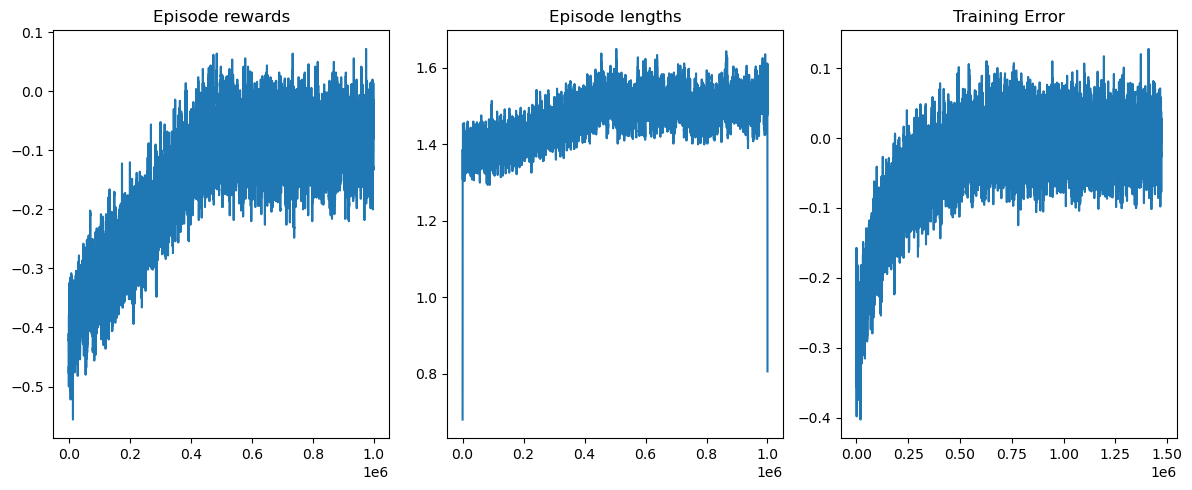

In [8]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards") #rewards over time, we see that negative feedbacks are often given
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve( # cumulative rewards of the recent n_episodes-many episodes
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length #normalize
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve( # training lengths
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show() #training error (the temporal differnce)

<img src="file://_static/img/tutorials/blackjack_training_plots.png">




## Visualising the policy



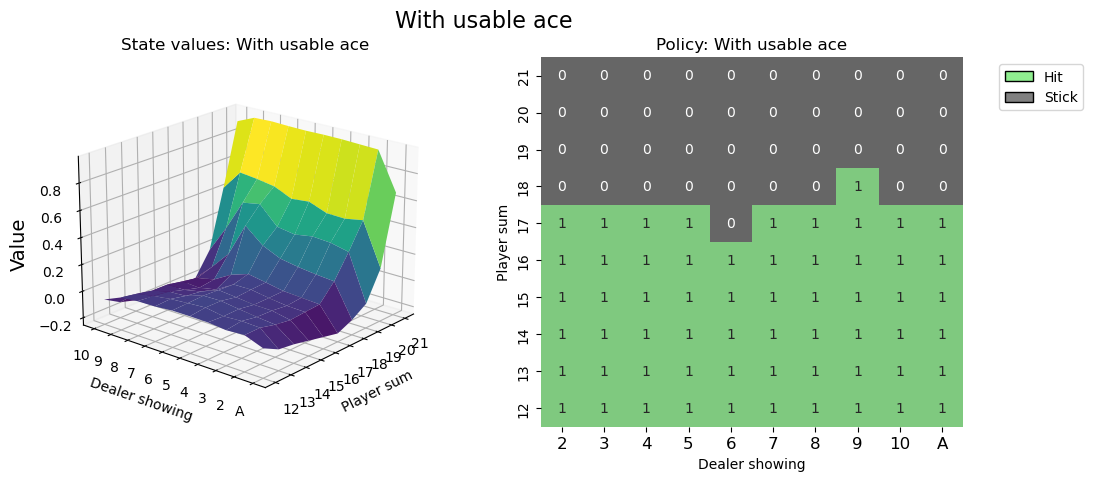

In [9]:
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict()
    policy = defaultdict()
    # record policy from the Q matrix
    for state, action_values in agent.q_values.items(): #q_value.items return the state-action pairs
        state_value[state] = float(np.max(action_values))
        policy[state] = int(np.argmax(action_values)) #the policy

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda state: state_value[(state[0], state[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    ) # take 1 (draw card) or not
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda state: policy[(state[0], state[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    # swapped x and y axis to fit with basic strategy
    ax2.set_ylabel("Player sum")
    ax2.set_xlabel("Dealer showing")
    ax2.set_yticklabels(range(12, 22))
    ax2.set_xticklabels(list(range(2, 11)) + ["A"], fontsize=12)
    ax2.invert_yaxis() # descending order, modified to fit with basic strategy visualization

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
def process(policy_grid):
    """
    transform the policy grid to match the original
    basic policy strategy visualization
    written by Allen Tong"""
    policy_grid=policy_grid.transpose()
    permutation = [9, 0, 1, 2, 3, 4, 5, 6, 7, 8] # move columns to where they should be
    idx = np.empty_like(permutation) #make a np array of the indices
    idx[permutation] = np.arange(len(permutation))
    policy_grid[:] = policy_grid[:, idx] #replace old np array
    return policy_grid
# print(policy_grid)
# move column of ace (A) to the rightmost
policy_grid=process(policy_grid)
# print(policy_grid)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

<img src="file://_static/img/tutorials/blackjack_with_usable_ace.png">




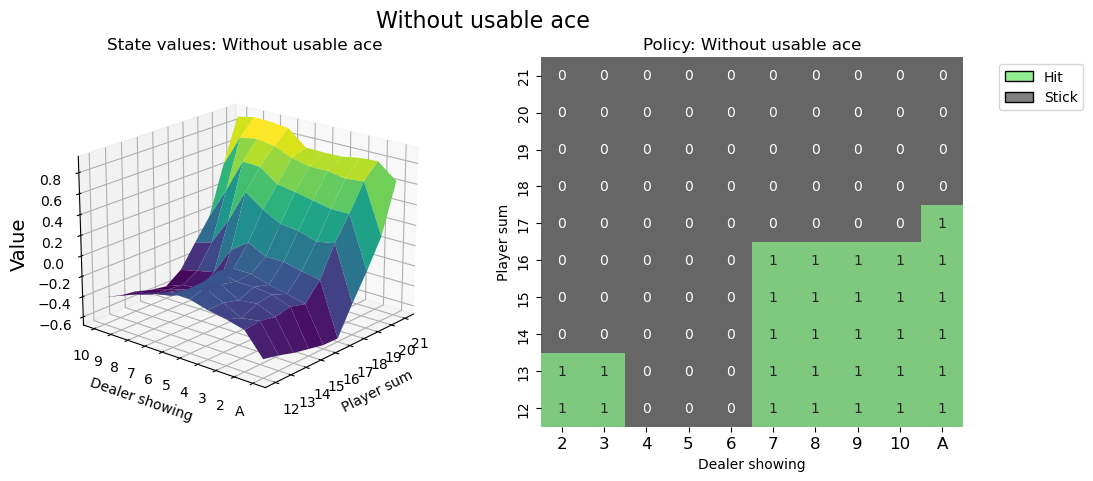

In [10]:
# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent, usable_ace=False)
policy_grid=process(policy_grid)
fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

In [11]:
env.close()

<img src="file://_static/img/tutorials/blackjack_without_usable_ace.png">

It's good practice to call env.close() at the end of your script,
so that any used resources by the environment will be closed.


